In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib.gridspec import GridSpec
import scanpy as sc
import muon as mu
import graphtools
import magic
from matplotlib.pyplot import rc_context
from matplotlib import gridspec
import os


from datashader.mpl_ext import dsshow
import datashader as ds

import matplotlib.colors
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../Code/')
from utils import read_dataset_log


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
figdir = '../../../Figures/Components'

In [3]:
harmony_vars = ['Site', 'sample_id']

In [5]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,cnmf_dir,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,/data/srlab1/TCAT/Data/PerDataset/AMPRA,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,/data/srlab1/TCAT/Data/PerDataset/Pancancer,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,/data/srlab1/TCAT/Data/PerDataset/TBRU,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/

## Prepare markers

In [6]:
raw_counts_fn = params.loc['UK-Covid', 'raw_counts_fn']
raw_counts_fn

'/data/srlab1/TCAT/Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixed.h5ad'

In [7]:
outdir = '../../../Data/PerDataset/UKCOVID'

In [8]:
adata = sc.read(raw_counts_fn)
# adata.obs['frac_ADT'] = adata.obs['nCount_ADT'] / (adata.obs['nCount_ADT'] + adata.obs['nCount_RNA'])
ind = adata.var['feature_types']=='Antibody Capture'

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


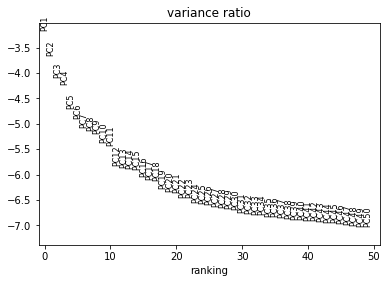

In [10]:
adata_RNA = adata[:,~ind].copy()
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA, zero_center=False)
sc.tl.pca(adata_RNA, use_highly_variable=True, zero_center=True)
sc.pl.pca_variance_ratio(adata_RNA, log=True, n_pcs=50)

In [ ]:
sc.external.pp.harmony_integrate(adata_RNA,  harmony_vars, max_iter_harmony = 30)


2024-02-19 18:17:32,127 - harmonypy - INFO - Iteration 1 of 30
2024-02-19 18:27:24,294 - harmonypy - INFO - Iteration 2 of 30
2024-02-19 18:37:49,040 - harmonypy - INFO - Iteration 3 of 30


In [ ]:
sc.pp.neighbors(adata_RNA, n_neighbors=5, n_pcs=36, use_rep='X_pca_harmony')

In [ ]:
outfn = os.path.join(outdir, 'RNA_logTP1K_ForMAGIC.h5ad')
print(outfn)

In [ ]:
adata_RNA.write(outfn)

In [ ]:
adata_RNA = sc.read(outfn)

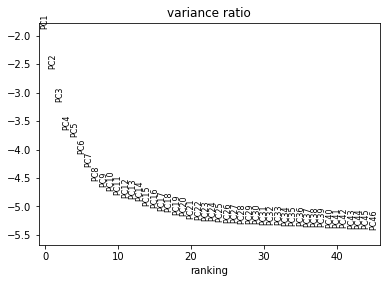

In [50]:
adata_ADT = adata[:,ind].copy()
sc.pp.normalize_per_cell(adata_ADT, counts_per_cell_after=1e4)
Z = adata_ADT.X.todense()
Z[Z==0] = np.nan
gmean = np.exp(np.nansum(np.log(Z+1), axis=1) / Z.shape[1])
Z = np.log((Z / gmean) + 1)
Z[np.isnan(Z)]=0
adata_ADT.X = np.array(Z)

sc.pp.scale(adata_ADT, zero_center=False, max_value=15)

sc.tl.pca(adata_ADT, zero_center=True)
sc.pl.pca_variance_ratio(adata_ADT, log=True, n_pcs=45)

In [51]:
sc.external.pp.harmony_integrate(adata_ADT,  harmony_vars, max_iter_harmony = 30)

2024-02-20 08:54:26,197 - harmonypy - INFO - Iteration 1 of 30
2024-02-20 09:03:41,672 - harmonypy - INFO - Iteration 2 of 30
2024-02-20 09:13:16,779 - harmonypy - INFO - Iteration 3 of 30
2024-02-20 09:22:43,299 - harmonypy - INFO - Iteration 4 of 30
2024-02-20 09:32:00,647 - harmonypy - INFO - Iteration 5 of 30
2024-02-20 09:41:38,041 - harmonypy - INFO - Iteration 6 of 30
2024-02-20 09:52:05,136 - harmonypy - INFO - Iteration 7 of 30
2024-02-20 09:59:34,538 - harmonypy - INFO - Iteration 8 of 30
2024-02-20 10:06:13,510 - harmonypy - INFO - Iteration 9 of 30
2024-02-20 10:12:12,036 - harmonypy - INFO - Iteration 10 of 30
2024-02-20 10:18:20,491 - harmonypy - INFO - Iteration 11 of 30
2024-02-20 10:23:22,349 - harmonypy - INFO - Iteration 12 of 30
2024-02-20 10:27:58,902 - harmonypy - INFO - Iteration 13 of 30
2024-02-20 10:32:51,425 - harmonypy - INFO - Converged after 13 iterations


In [52]:
sc.pp.neighbors(adata_ADT, n_neighbors=5, n_pcs=32, use_rep='X_pca_harmony')

In [53]:
outfn = os.path.join(outdir, 'ADT_TP10KCLR_ForMAGIC.h5ad')
print(outfn)

../../../Data/PerDataset/UKCOVID/ADT_TP10KCLR_ForMAGIC.h5ad


In [54]:
adata_ADT.write(outfn)

In [55]:
adata_ADT = sc.read(outfn)

In [56]:
rna_markers = ['TRAC', 'TRGC1', 'TRDC', 'TRBC1', 'IL2RA', 'FOXP3', 'SELL', 'CCR7', 'KLRB1', 'RTKN2', 'IL7R', 'PASK', 'GATA3',
               'CCR4', 'STAT1', 'IRF4', 'TBX21', 'IFNG', 'CCR5', 'CXCR3', 'CCR6', 'RORA', 'CCL20', 'IL4R', 'STAT4',  'STAT6',  'RORC', 'CCR1', 'IL10']

In [57]:
set(rna_markers) - set(adata_RNA.var.index)

set()

In [58]:
adt_markers = ['AB_CD3-1', 'AB_CD4-2',
               'AB_CD8', 'AB_CD45RA', 'AB_CD45RO',  'AB_CD18', 'AB_CD161',  'AB_CD195', 
               'AB_CD25', 'AB_CD127', 
               'AB_CD27-1',
               'AB_TCR-Vd2', 'AB_TCR-V-7.2', 'AB_TCR-V-9', 'AB_abTCR', 'AB_gdTCR',
               'AB_CD31', 'AB_CD62L', 'AB_CCR7',
               'AB_CD314',
               'AB_CD38-1', 'AB_CD39',
              'AB_CD94', 'AB_CD49b', 'AB_CD28'] 

In [59]:
sorted(adata_ADT.var.index)

['AB_B7-H4',
 'AB_CCR3',
 'AB_CCR7',
 'AB_CD10',
 'AB_CD101',
 'AB_CD103',
 'AB_CD106',
 'AB_CD107a',
 'AB_CD112',
 'AB_CD117',
 'AB_CD11a',
 'AB_CD11b-1',
 'AB_CD11c',
 'AB_CD122',
 'AB_CD123',
 'AB_CD124',
 'AB_CD127',
 'AB_CD133-2',
 'AB_CD137',
 'AB_CD137L',
 'AB_CD138-2',
 'AB_CD14-1',
 'AB_CD141',
 'AB_CD144',
 'AB_CD146',
 'AB_CD15',
 'AB_CD150',
 'AB_CD152',
 'AB_CD154',
 'AB_CD155',
 'AB_CD158',
 'AB_CD158b',
 'AB_CD158e1',
 'AB_CD158f',
 'AB_CD16',
 'AB_CD161',
 'AB_CD163',
 'AB_CD169',
 'AB_CD178',
 'AB_CD18',
 'AB_CD184',
 'AB_CD185',
 'AB_CD19',
 'AB_CD194',
 'AB_CD195',
 'AB_CD196',
 'AB_CD1a',
 'AB_CD1c',
 'AB_CD1d',
 'AB_CD2',
 'AB_CD20',
 'AB_CD204',
 'AB_CD206',
 'AB_CD207',
 'AB_CD209',
 'AB_CD21',
 'AB_CD22',
 'AB_CD223',
 'AB_CD224',
 'AB_CD226-2',
 'AB_CD23',
 'AB_CD235ab',
 'AB_CD24',
 'AB_CD244',
 'AB_CD25',
 'AB_CD252',
 'AB_CD254',
 'AB_CD257',
 'AB_CD258',
 'AB_CD26',
 'AB_CD267',
 'AB_CD268',
 'AB_CD269',
 'AB_CD27-1',
 'AB_CD272',
 'AB_CD273',
 'AB_CD274',


In [60]:
set(adt_markers) - set(adata_ADT.var.index)

set()

In [61]:
adt_markers = list(set(adt_markers).intersection(adata_ADT.var.index))

In [150]:
G = graphtools.Graph(data=adata_RNA.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_RNA.X, graph=G)
markers_magic = magic_operator.transform(X=adata_RNA[:, rna_markers].X)
markers_magic = pd.DataFrame(markers_magic, index=adata_RNA.obs.index, columns=rna_markers)

Running MAGIC on 612982 cells and 24737 genes.


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


Using precomputed graph and diffusion operator...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:426: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  "Input matrix contains unexpressed genes. "


Calculating imputation...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.11 seconds.


In [151]:
G = graphtools.Graph(data=adata_ADT.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_ADT.X, graph=G)
markers_magic_adt = magic_operator.transform(X=adata_ADT[:, adt_markers].X)
markers_magic_adt = pd.DataFrame(markers_magic_adt, index=adata_ADT.obs.index, columns=adt_markers)

Running MAGIC on 612982 cells and 192 genes.
Using precomputed graph and diffusion operator...


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


Calculating imputation...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.07 seconds.


In [152]:
for g in adt_markers:
    markers_magic[g] = markers_magic_adt[g]
    
# markers_magic['frac_ADT'] = adata.obs['frac_ADT']

In [153]:
outfn = os.path.join(outdir, 'ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/UKCOVID/ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [154]:
markers_magic.to_csv(outfn, sep='\t')

In [155]:
markers_magic = pd.read_csv(outfn, sep='\t', index_col=0)

In [156]:
markers_magic.head()

,TRAC,TRGC1,TRDC,TRBC1,IL2RA,FOXP3,SELL,CCR7,KLRB1,RTKN2,...,AB_CD62L,AB_CD31,AB_CD3-1,AB_CD45RA,AB_abTCR,AB_CD4-2,AB_CD8,AB_CD195,AB_CD38-1,AB_gdTCR
covid_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,0.323651,0.128507,0.034384,0.669584,0.053477,0.000000,0.695090,0.033160,0.469396,0.078253,...,0.852456,0.553541,2.060499,2.445477,2.353760,0.821391,2.614088,2.323170,1.343210,6.459019
AAACCTGAGAGTAATC-MH9179824,1.066141,0.022205,0.009538,0.417891,0.264447,0.110463,0.752210,0.146583,1.152650,1.044695,...,0.988748,0.421402,1.260994,1.226835,1.815276,1.775513,0.292135,1.386103,1.111526,6.760693
AAACCTGAGAGTGAGA-MH9179824,1.144493,0.009007,0.000755,0.753302,0.745483,0.914966,1.339371,0.341873,0.373347,0.799132,...,2.946448,0.226051,2.123742,1.322198,2.438513,1.667446,2.463939,1.564633,0.771255,6.191789
AAACCTGAGGAATCGC-MH9179824,0.486390,0.000000,0.001294,0.614035,0.526169,0.035784,1.582323,1.338660,0.502749,0.451260,...,2.362706,0.258934,2.632654,1.445213,3.250441,3.219191,0.358289,1.644241,1.059226,6.326955
AAACCTGAGTGTTGAA-MH9179824,0.453379,0.049092,0.116070,0.516042,0.049502,0.075858,0.396103,0.015246,0.353282,0.059974,...,0.789329,0.412884,1.937516,1.293197,2.484673,2.152553,0.786610,2.307220,1.122550,6.632280


In [157]:
unsmoothed_markers = pd.DataFrame(np.concatenate([adata_RNA[:, rna_markers].X.toarray(), np.array(adata_ADT[:, adt_markers].X)], axis=1), index=adata_RNA.obs.index,
             columns=(rna_markers+adt_markers))

In [158]:
outfn = os.path.join(outdir, 'ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/UKCOVID/ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [159]:
unsmoothed_markers.to_csv(outfn, sep='\t')

In [160]:
markers = list(markers_magic.columns)

## Protein-RNA correlations

In [161]:
from scipy.stats import pearsonr

In [162]:
prot_pairs = [('CCR7', 'AB_CCR7'),
              ('SELL', 'AB_CD62L'),
             ('IL2RA', 'AB_CD25'),
             ('FOXP3', 'AB_CD25'),
             ('TRDC', 'AB_gdTCR'),
             ('TRDC', 'AB_abTCR')]

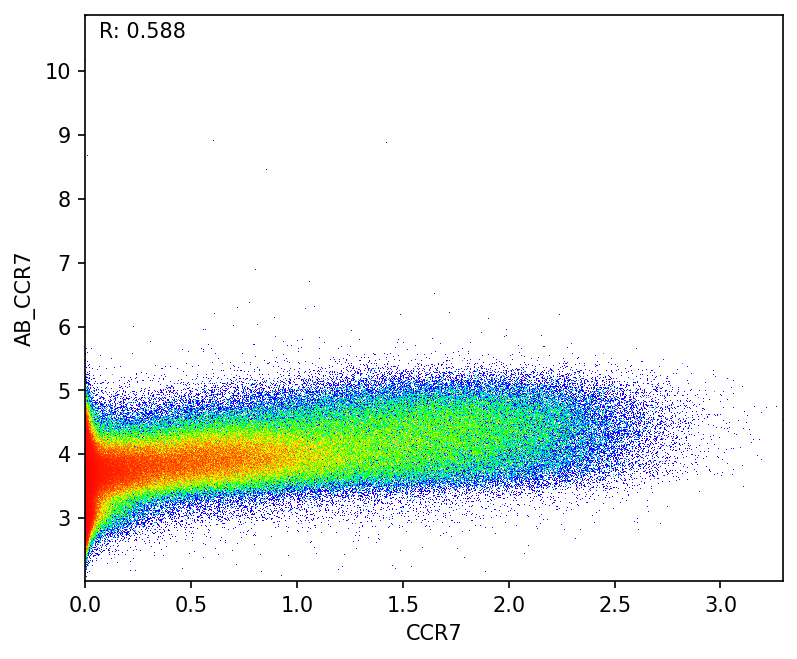

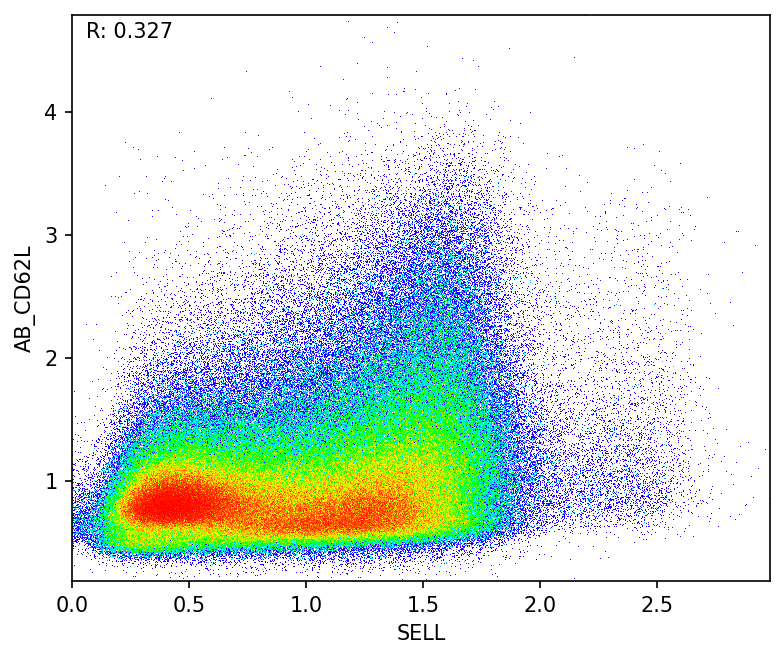

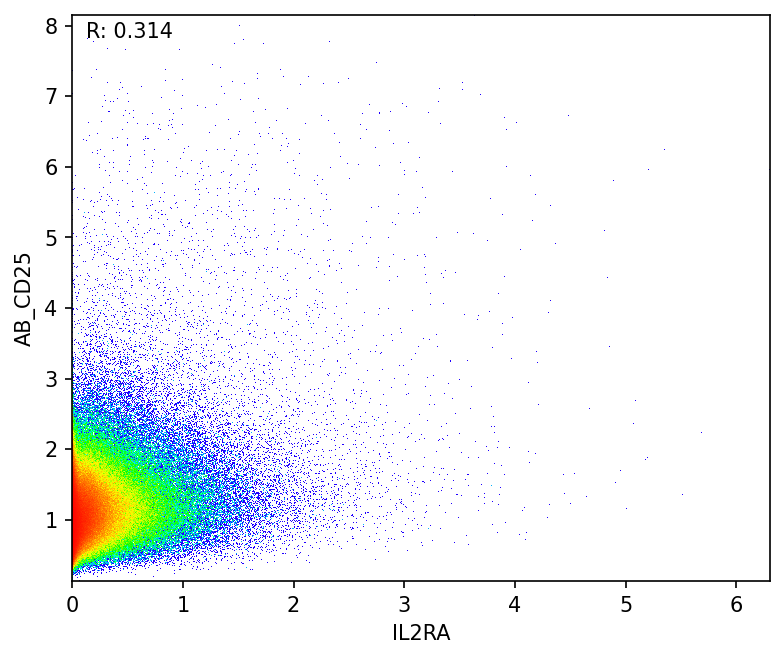

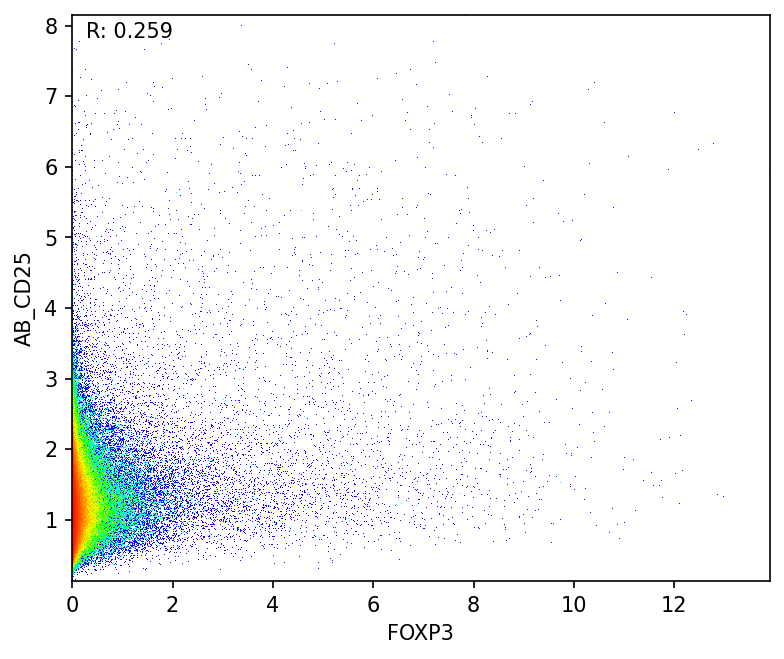

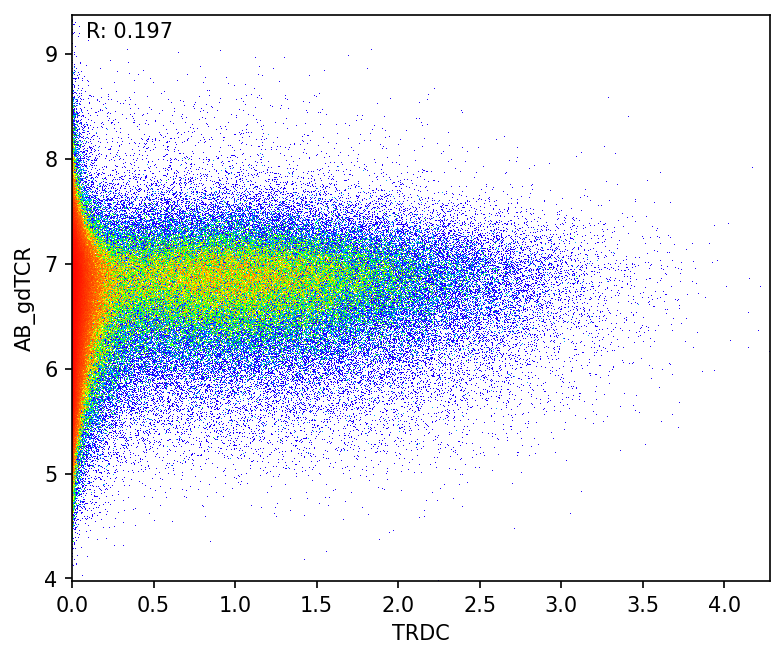

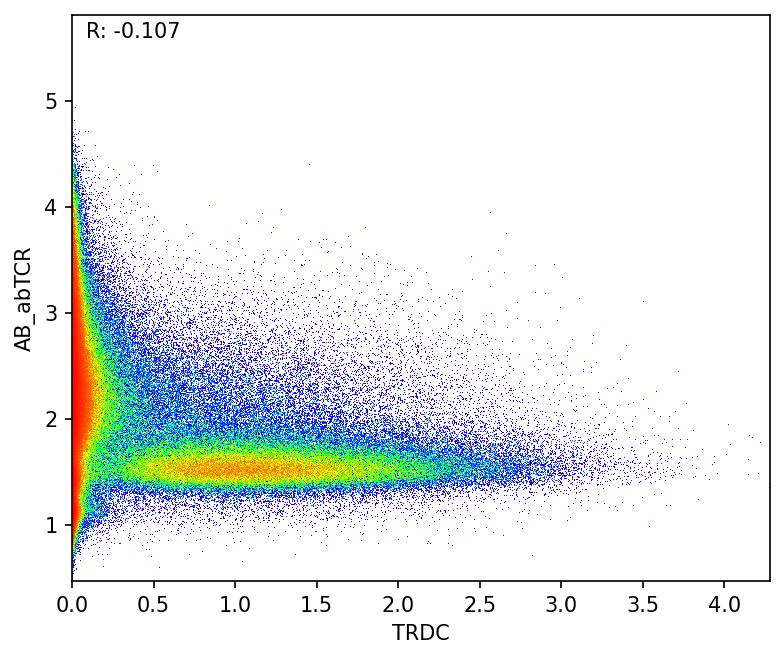

In [163]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(markers_magic[gene], markers_magic[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':markers_magic[gene], 'y':markers_magic[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/datashader/mpl_ext.py:144: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  "EqHistColorMapper warning: Histogram equalization did not converge."


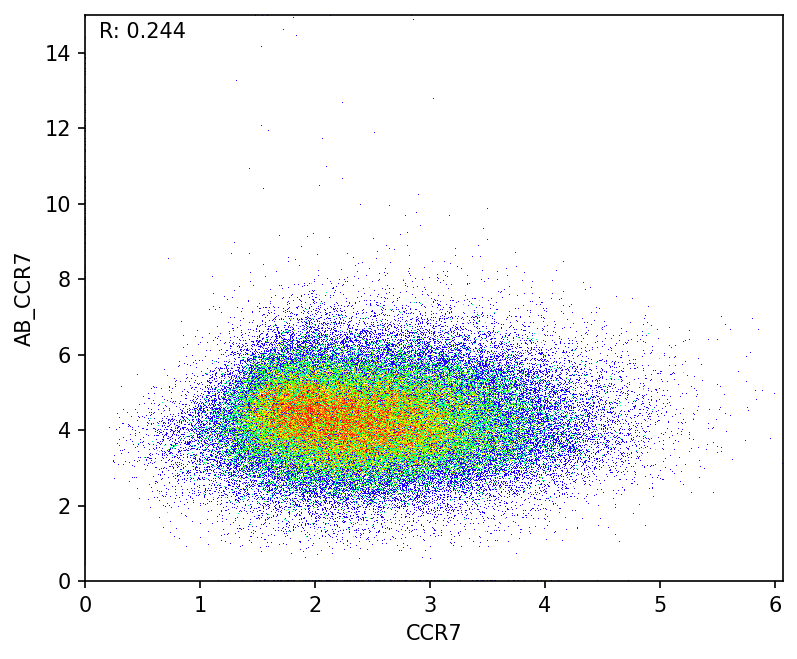

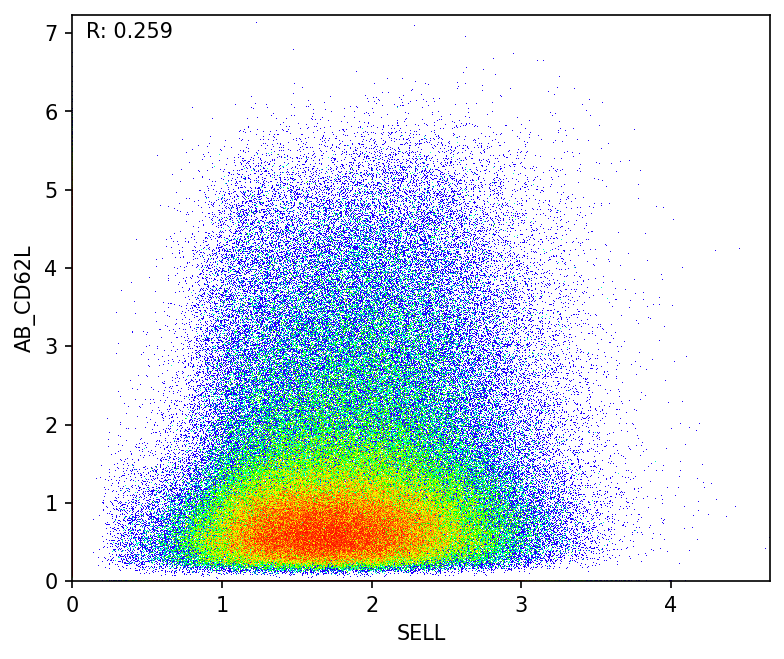

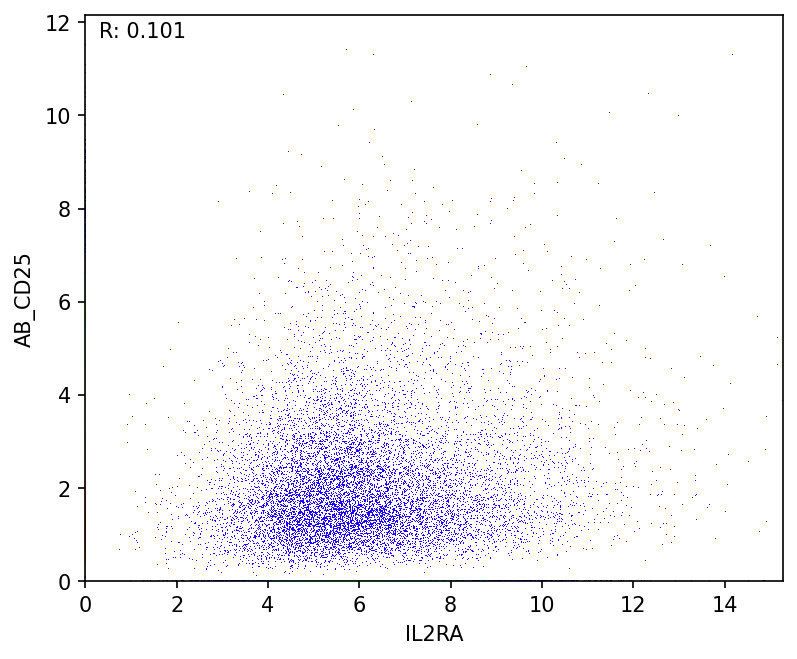

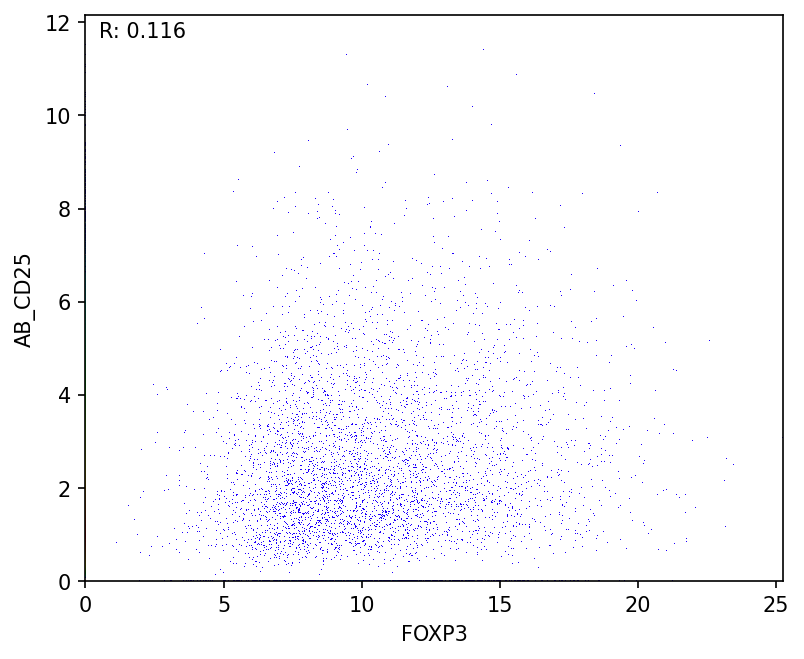

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/datashader/mpl_ext.py:144: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  "EqHistColorMapper warning: Histogram equalization did not converge."
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/datashader/mpl_ext.py:144: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  "EqHistColorMapper warning: Histogram equalization did not converge."


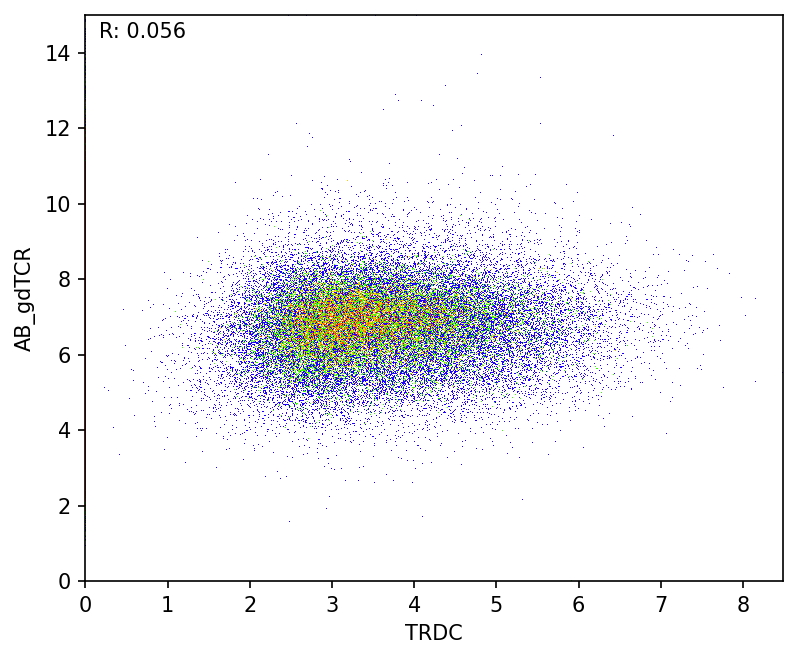

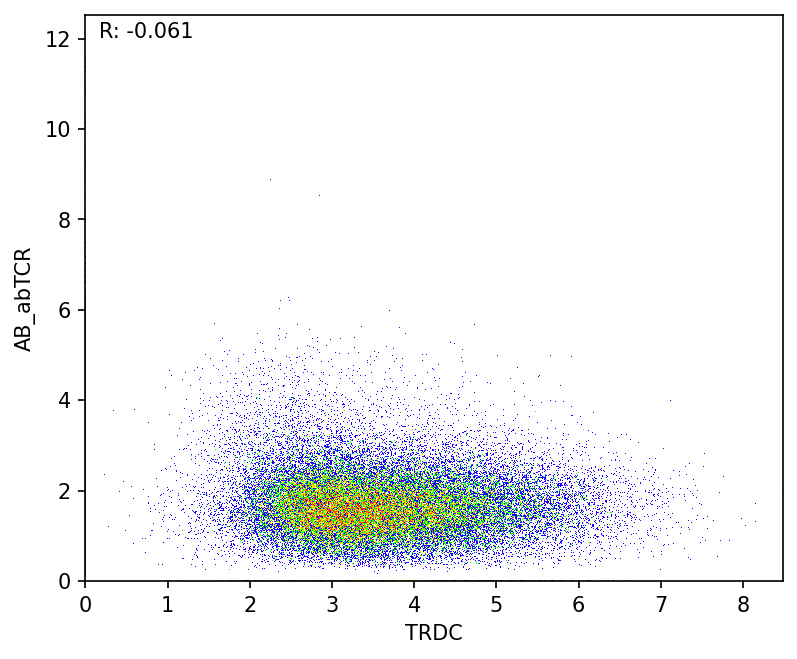

In [164]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(unsmoothed_markers[gene], unsmoothed_markers[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':unsmoothed_markers[gene], 'y':unsmoothed_markers[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

## Lineage marker gating - RNA and proteins

In [165]:
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)
    
def gate(data, g1, g2, ind=None, vertical_gate=None, horizontal_gate=None, quadrant_gate=None,
         labfontsize=9, plot_labeled=False, upper_only=False, ax=None):
    
    
    if ax is None:
        fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.92)
        ax = fig.add_subplot(gs[0])

    if ind  is None:
        ind = pd.Series(np.array([True]*data.shape[0]), data.index)
    
    
    x = data.loc[ind, g1]
    y = data.loc[ind, g2]
    
    dsshow(pd.DataFrame({'x':x, 'y':y}), ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    ax.set_xlabel(g1, fontsize=labfontsize)
    ax.set_ylabel(g2, fontsize=labfontsize)

    
    if vertical_gate is not None:
        xlim = ax.get_xlim()
        ax.hlines(y=vertical_gate['vthresh'], xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k', linewidth=1)
        ax.set_xlim(xlim)
        
            
        initial_res = (data.loc[ind, g2]>vertical_gate['vthresh']).replace({True:vertical_gate['above_name'], False:vertical_gate['below_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
    elif horizontal_gate is not None:
        ylim = ax.get_ylim()
        ax.vlines(x=horizontal_gate['hthresh'], ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', linewidth=1)
        ax.set_ylim(ylim)
        
        initial_res = (data.loc[ind, g1]>horizontal_gate['hthresh']).replace({False:horizontal_gate['left_name'], True:horizontal_gate['right_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
        
        
    elif quadrant_gate is not None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if not upper_only:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=xlim[0]-1, xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=ylim[0]-1, ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)
        else:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=quadrant_gate['hthresh'], xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=quadrant_gate['vthresh'], ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)            
            

        indh = data.loc[ind, g1]> quadrant_gate['hthresh']
        indv = data.loc[ind, g2]> quadrant_gate['vthresh']
        final_res = ind.replace(False,np.nan)
        for hval,vval, lab in [[False, False, quadrant_gate['ll']], [True, False, quadrant_gate['lr']], [False, True, quadrant_gate['ul']], [True, True, quadrant_gate['ur']]]:
            tolab = (indh==hval) & (indv==vval)
            final_res.loc[tolab.index[tolab]] = lab
            
            
    if plot_labeled:
        fig = plt.figure(constrained_layout=True, figsize=(2.4, 2.), dpi=200)
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.92)
        ax2 = fig.add_subplot(gs[0])
        dat = pd.concat([x,y,final_res], axis=1)
        dat.columns = [g1, g2, 'label']
        for (k,g) in dat.groupby('label'):
            ax2.scatter(g[g1], g[g2], label=k, s=.5, edgecolor='None')
        ax2.legend(bbox_to_anchor=(1,1), markerscale=3, fontsize=6)
        
        
        
    return(final_res, ax)

In [166]:
gating = pd.DataFrame(index=markers_magic.index, columns=['gdT', 'MAIT', 'CD4_vs_CD8', 'Treg', 'CD4_Conv', 'CD8_Conv'])

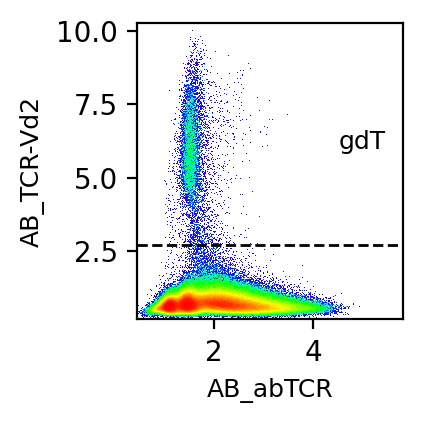

In [167]:
g1 = 'AB_abTCR'
g2 = 'AB_TCR-Vd2'   
vgate = {'vthresh':2.7, 'above_name':'gdT', 'below_name':'ab'}
gating['gdT'], ax = gate(markers_magic, g1, g2, ind=None, vertical_gate=vgate, plot_labeled=False)

ax.text(4.5,6, 'gdT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_gdT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_gdT.pdf'))

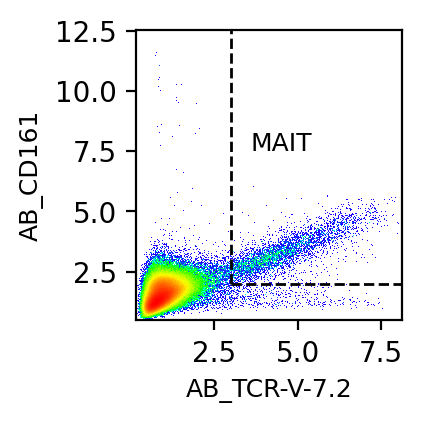

In [168]:
g1 = 'AB_TCR-V-7.2'
g2 = 'AB_CD161'  
gating['MAIT'],ax = gate(markers_magic, g1, g2, ind=gating['gdT']=='ab',
                      quadrant_gate={'vthresh':2.0, 'hthresh':3, 'ur':'MAIT', 'ul':'ab', 'll':'ab', 'lr':'ab'}, plot_labeled=False, upper_only=True)
ax.text(3.6,7.5, 'MAIT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_MAIT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_MAIT.pdf'))

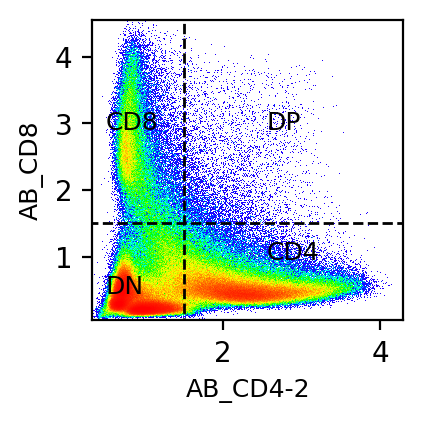

In [169]:
g1 = 'AB_CD4-2'
g2 = 'AB_CD8'    
gating['CD4_vs_CD8'],ax = gate(markers_magic, g1, g2, ind=gating['MAIT']=='ab', quadrant_gate={'vthresh':1.5, 'hthresh':1.5, 'll':'DN', 'ul':'CD8', 'ur':'DP', 'lr':'CD4'})

ax.text(.5, 2.9, 'CD8', fontsize=9)
ax.text(2.55, .95, 'CD4', fontsize=9)
ax.text(2.55,2.9, 'DP', fontsize=9)
ax.text(.5, .45, 'DN', fontsize=9)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], xlim[1]+.15)

plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_CD4CD8.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_CD4CD8.pdf'))

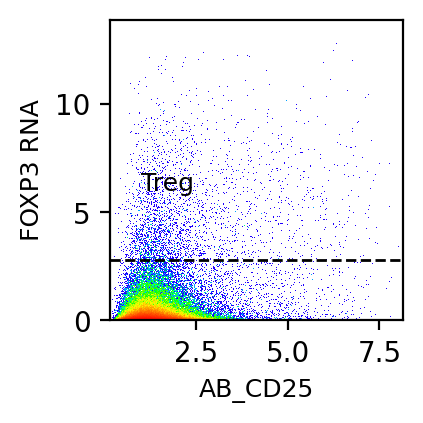

In [170]:
g1 = 'AB_CD25'     
g2 = 'FOXP3'

gating['Treg'],ax = gate(markers_magic, g1, g2, ind=gating['CD4_vs_CD8']=='CD4', vertical_gate={'vthresh':2.8, 'above_name':'Treg', 'below_name':'CD4'},
                      plot_labeled=False)

ax.text(1, 6, 'Treg', fontsize=9)
ax.set_ylabel('FOXP3 RNA', fontsize=9)

plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_Treg.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_Treg.pdf'))

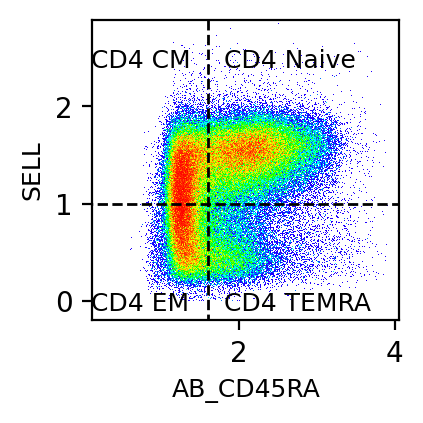

In [180]:
g1 = 'AB_CD45RA'     
g2 = 'SELL'
gating['CD4_Naive'], ax = gate(markers_magic, g1, g2, ind=(gating['Treg']=='CD4'),
                           quadrant_gate={'vthresh':1., 'hthresh':1.6, 'll':'CD4_Memory', 'ur':'CD4_Naive', 'ul':'CD4_Memory', 'lr':'CD4_TEMRA'},
                           plot_labeled=False)

ax.text(1.8, 2.4, 'CD4 Naive', fontsize=9)
ax.text(1.8, -.1, 'CD4 TEMRA', fontsize=9)

ax.text(0.1, 2.4, 'CD4 CM', fontsize=9)
ax.text(0.1, -.1, 'CD4 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0]-.5, xlim[1]+.15)
ax.set_ylim(ylim[0]-.2, ylim[1]+.05)


plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_CD4Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_UKCOVID_CD4Naive.pdf'))

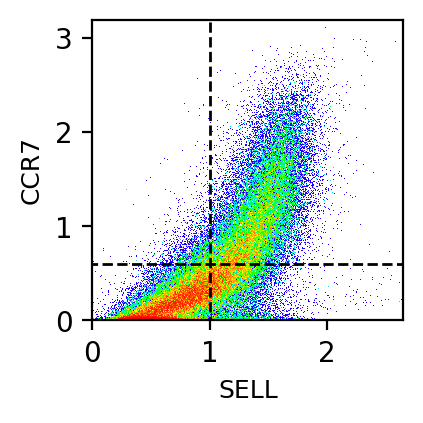

In [181]:
g1 = 'SELL'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_Naive']=='CD4_Memory'), quadrant_gate={'vthresh':.6, 'hthresh':1, 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'})


(covid_index
 AAACCTGAGAAACCTA-MH9179824           NaN
 AAACCTGAGAGTAATC-MH9179824    CD4_Memory
 AAACCTGAGAGTGAGA-MH9179824           NaN
 AAACCTGAGGAATCGC-MH9179824    CD4_Memory
 AAACCTGAGTGTTGAA-MH9179824    CD4_Memory
                                  ...    
 BGCV15_TTTGGTTTCAAGATCC-1            NaN
 BGCV15_TTTGTCACAAGCCATT-1            NaN
 BGCV15_TTTGTCACAGACACTT-1            NaN
 BGCV15_TTTGTCAGTTACGGAG-1            NaN
 BGCV15_TTTGTCATCGAATGGG-1            NaN
 Name: CD4_Naive, Length: 612982, dtype: object,
 <AxesSubplot:xlabel='SELL', ylabel='AB_CD27-1'>)

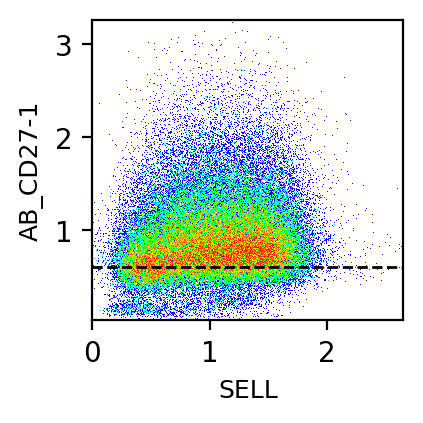

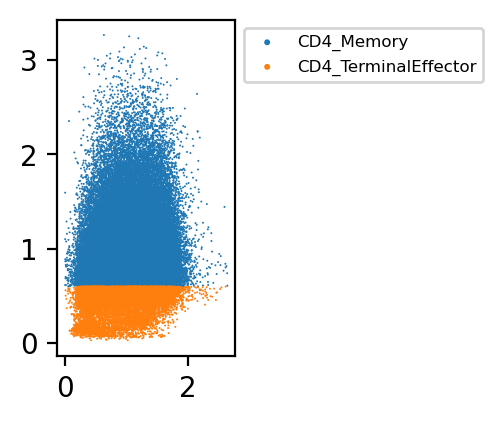

In [182]:
g1 = 'SELL'
g2 = 'AB_CD27-1'     
gate(markers_magic, g1, g2, ind=(gating['CD4_Naive']=='CD4_Memory'),
                                   vertical_gate={'vthresh':.6, 'above_name':'CD4_Memory', 'below_name':'CD4_TerminalEffector'},
                                   plot_labeled=True)


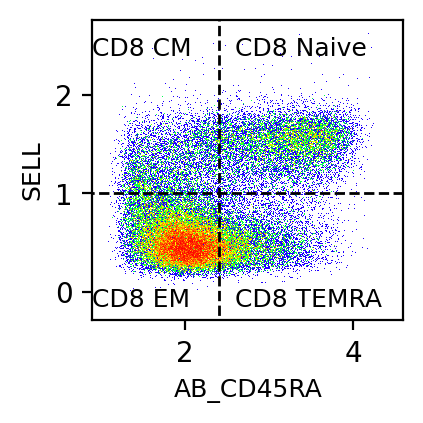

In [187]:
g1 = 'AB_CD45RA'     
g2 = 'SELL'
gating['CD8_Conv'],ax = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':1, 'hthresh':2.4, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)


ax.text(2.6, 2.4, 'CD8 Naive', fontsize=9)
ax.text(2.6, -.15, 'CD8 TEMRA', fontsize=9)

ax.text(0.9, 2.4, 'CD8 CM', fontsize=9)
ax.text(0.9, -.15, 'CD8 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0]-.2, xlim[1]+.35)
ax.set_ylim(ylim[0]-.3, ylim[1]+.15)


plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD8Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD8Naive.pdf'))

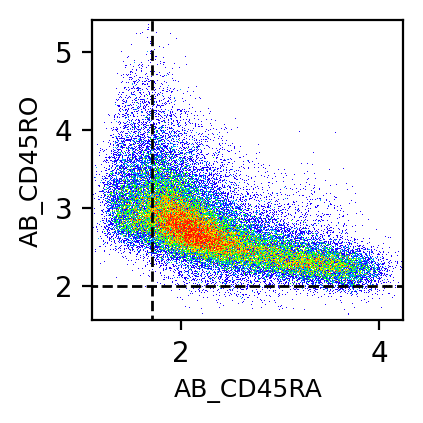

In [188]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD45RO'
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':2, 'hthresh':1.7, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)

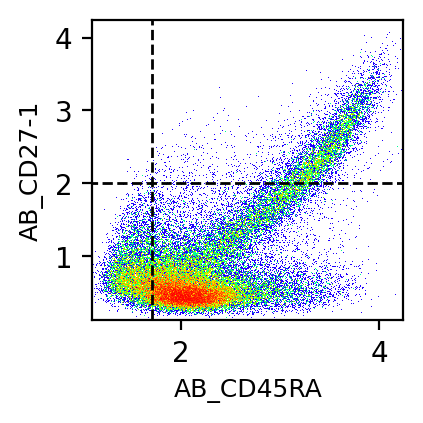

In [189]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD27-1'     
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':2, 'hthresh':1.7, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)

In [190]:
label = gating.apply(lambda x: x[x.last_valid_index()], axis=1)

In [191]:
label.value_counts()

DN            352231
CD4_Memory     91339
CD4_Naive      73912
CD8_EM         27466
CD4_TEMRA      20367
CD8_Naive      10956
CD8_TEMRA       8944
gdT             8454
CD8_CM          6085
DP              5736
MAIT            4694
Treg            2798
dtype: int64

In [192]:
outfn = os.path.join(outdir, 'ManualGating.Magic.20230831.tsv')
print(outfn)

../../../Data/PerDataset/UKCOVID/ManualGating.Magic.20230831.tsv


In [193]:
gating.to_csv(outfn, sep='\t')

In [194]:
outfn = os.path.join(outdir, 'ManualGating.Magic.FinalLabel.20230831.tsv')
print(outfn)

../../../Data/PerDataset/UKCOVID/ManualGating.Magic.FinalLabel.20230831.tsv


In [195]:
label.to_csv(outfn, sep='\t')